# Topographic Wetness Index (TWI)

This tutorial demonstrates using PyWBT to compute TWI for a watershed in Houston, Texas.

In [1]:
from __future__ import annotations

from pathlib import Path

import pywbt

We use USGS's 3D Elevation Program (3DEP) to download the DEM data and compute TWI using PyWBT. PyWBT has a modules called `dem_utils` that contains utiltiy functions for downloading and reading DEM data from 3DEP and/or NASADEM sources. Note that the module has some additional dependencies that need to be installed.

In [2]:
fname = Path("data/dem_tx_10m.tif")
fname.parent.mkdir(parents=True, exist_ok=True)
if not fname.exists():
    bbox = (-95.2394, 29.6264, -95.1749, 29.7186)
    pywbt.dem_utils.get_3dep(bbox, fname, 10, to_5070=True)

For working with PyWBT, you need give the sequence of the WBT tools that you want to invoke with their respective parameters. In this example, we use the following sequence of tools:

1. `BreachDepressions`: An alternative to filling depressions in a DEM. This tool modifies the DEM to remove all depressions and flat areas, allowing water to flow off the edge of the DEM.
2. `D8Pointer`: A tool for generating flow pointer grid using the simple D8 algorithm.
3. `DownslopeFlowpathLength`: A tool for computing downslope flowpath length grid.
4. `D8FlowAccumulation`: A tool for computing flow accumulation grid using the D8 algorithm.
5. `Slope`: A tool for computing slope grid.
6. `WetnessIndex`: A tool for computing the topographic wetness index (TWI) grid.

In [3]:
wbt_args = {
    "BreachDepressions": [f"-i={fname.name}", "--fill_pits", "-o=dem_corr.tif"],
    "D8Pointer": ["-i=dem_corr.tif", "-o=fdir.tif"],
    "DownslopeFlowpathLength": ["--d8_pntr=fdir.tif", "-o=downslope_fp_length.tif"],
    "D8FlowAccumulation": ["-i=fdir.tif", "--pntr", "--out_type='specific contributing area'", "-o=sca.tif"],
    "Slope": ["-i=dem_corr.tif", "--units=degrees", "-o=slope.tif"],
    "WetnessIndex": ["--sca=sca.tif", "--slope=slope.tif", "-o=twi.tif"],
}
save_dir = Path("results")
pywbt.whitebox_tools(fname.parent, wbt_args, ("twi.tif", "downslope_fp_length.tif"), save_dir)

Let's plot the TWI and downslope flowpath length for the watershed in Houston, Texas.

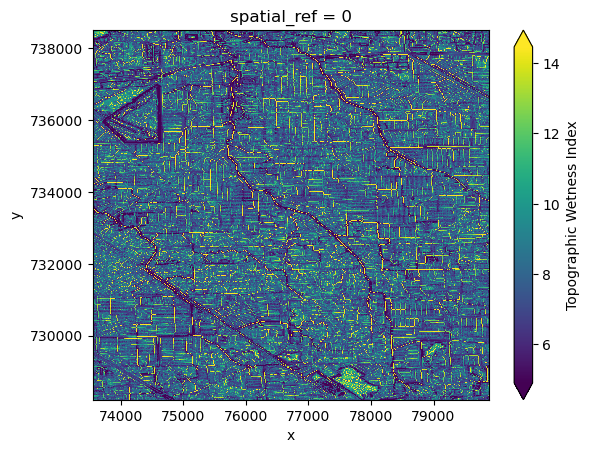

In [4]:
plot_dir = Path("images")
plot_dir.mkdir(parents=True, exist_ok=True)
twi = pywbt.dem_utils.tif_to_da(save_dir / "twi.tif", long_name="Topographic Wetness Index")
ax = twi.plot.imshow(robust=True)
ax.figure.savefig(plot_dir / "twi.png", dpi=90)

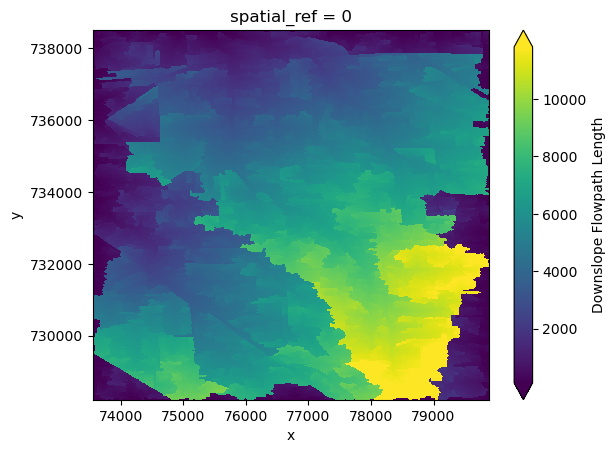

In [5]:
dwslope = pywbt.dem_utils.tif_to_da(save_dir / "downslope_fp_length.tif", long_name="Downslope Flowpath Length")
_ = dwslope.plot.imshow(robust=True)